In [1]:
%pip install pandas==1.5.1
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 2.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 13.4 MB/s 


In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import image as mpimg
import re
from PIL import Image
import pandas as pd
from torchmetrics import TweedieDevianceScore
sns.set_style('whitegrid')

# Random split function

In [3]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

# Setting up data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH='/content/drive/MyDrive/Data/'

In [7]:
with open(PATH+"listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open(PATH+"test_listings_image.pkl", "rb") as fh:
    data_test = pickle.load(fh)

In [8]:
import glob
import os


#os.path.basename(csv_files[0])
img_files = glob.glob(PATH+'Images'+ "/*")

In [9]:
list_ids=[img_file.replace(PATH+'Images/',"") for img_file in img_files]
print('There are ',len(list_ids),' differents property reference ids in the image dataset')

There are  126  differents property reference ids in the image dataset


In [10]:
data_ids=data['Property Reference Id'].to_list()
data_test_ids=data_test['Property Reference Id'].to_list()
print('There are ',len(data_ids),' differents property reference ids in the general dataset')
print('There are ',len(data_test_ids),' differents property reference ids in the test dataset')

There are  20000  differents property reference ids in the general dataset
There are  10000  differents property reference ids in the test dataset


In [11]:
print('There are ',len(set(list_ids)-set(data_ids)),' property reference ids in the image dataset but not in the general dataset')
print('There are ',len(set(data_ids)-set(list_ids)),' property reference ids in the general dataset but not in the image dataset')
print('There are ',len(set(list_ids)-set(data_test_ids)),' property reference ids in the image dataset but not in the test dataset')
print('There are ',len(set(data_test_ids)-set(list_ids)),' property reference ids in the test dataset but not in the image dataset')

There are  49  property reference ids in the image dataset but not in the general dataset
There are  14622  property reference ids in the general dataset but not in the image dataset
There are  86  property reference ids in the image dataset but not in the test dataset
There are  8385  property reference ids in the test dataset but not in the image dataset


In [12]:
len(set(data_ids))

14699

In [13]:
#data['Property Reference Id'].value_counts()

In [14]:
#data[data['Property Reference Id']==data['Property Reference Id'].value_counts().index[0]]

In [15]:
#Getting the folder corresponding to ids in both the img dataset and the general data set
list_folder_workable=[x for x in img_files if x.replace(PATH+'Images/',"") in data_ids]
list_id_workable=[x.replace(PATH+'Images/',"") for x in img_files if x.replace(PATH+'Images/',"") in data_ids]
list_id_workable_test=[x.replace(PATH+'Images/',"") for x in img_files if x.replace(PATH+'Images/',"") in data_test_ids]
print('train:',len(list_id_workable),'test:',len(list_id_workable_test))

train: 77 test: 40


In [16]:
#Keeping only data for those
data_sub=data[data['Property Reference Id'].isin(list_id_workable)].drop_duplicates(subset='Property Reference Id')
data_sub

,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Demand,Floor,Geo Canton,Geo City,Geo Zip,Has Balcony,...,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated
600,False,APPT,"July 11, 2018","October 1, 2018",7.0,3.0,LU,Emmen,6020,False,...,7,220.0,1220.0,22.0,1000.0,9201.61.6571,56.0,Apartment,NaN,NaN
1130,NaN,APPT,"June 29, 2021","October 1, 2021",5.0,1.0,SZ,Ingenbohl,6440,NaN,...,10,250.0,1968.0,21.0,1718.0,5011.24.4593,94.0,Apartment,2013.0,2013.0
1261,False,APPT,"August 21, 2018","October 1, 2018",0.0,2.0,SZ,Ingenbohl,6440,False,...,5,220.0,2022.0,22.0,1802.0,5011.38.4593,93.0,Apartment,NaN,NaN
1364,NaN,APPT,"January 8, 2021",NaN,1.0,2.0,LU,Luzern,6005,NaN,...,9,230.0,1600.0,21.0,1370.0,9135.61.0065,76.0,Apartment,1956.0,2014.0
1604,NaN,APPT,"August 6, 2020",NaN,0.0,3.0,LU,Ebikon,6030,NaN,...,7,200.0,1850.0,19.0,1650.0,2905.61.6571,95.0,Apartment,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18021,NaN,APPT,"August 2, 2021",NaN,10.0,0.0,SZ,Ingenbohl,6440,NaN,...,11,240.0,1980.0,21.0,1740.0,5011.24.7822,93.0,Apartment,2013.0,2013.0
18698,NaN,APPT,"January 20, 2020","April 1, 2020",4.0,2.0,SZ,Ingenbohl,6440,NaN,...,7,120.0,1370.0,25.0,1250.0,4731.61.5664,55.0,Apartment,2014.0,2014.0
19021,False,APPT,"December 18, 2017","April 1, 2018",0.0,3.0,LU,Luzern,6014,False,...,5,250.0,2135.0,18.0,1885.0,0214.26.6915,118.0,Apartment,NaN,NaN
19136,False,APPT,"May 7, 2018","July 1, 2018",0.0,2.0,SZ,Ingenbohl,6440,False,...,7,300.0,2186.0,18.0,1886.0,4731.61.3230,123.0,Apartment,NaN,NaN


In [17]:
def image_plot(path):
  files=glob.glob(path+ "/*")
  n_files=len(files)
  print('There are ',n_files,' images for this id')
  #f, axarr = plt.subplots(n_files,1) 
  for i,file in enumerate(files):
    #image = mpimg.imread(file) also works btw
    image=Image.open(file)
    print(np.array(image).shape)
    plt.imshow(image)
    plt.show()
    #plt.imshow(image.transpose(Image.ROTATE_90))
    #plt.show()
    #plt.imshow(image.transpose(Image.FLIP_LEFT_RIGHT)) 
    #plt.show()
    #axarr[i].imshow(image)
  #plt.show()

There are  4  images for this id
(212, 320, 3)


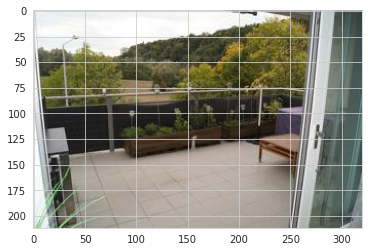

(320, 212, 3)


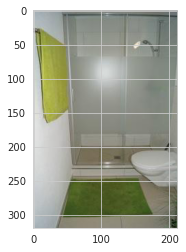

(212, 320, 3)


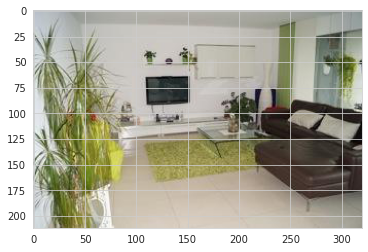

(212, 320, 3)


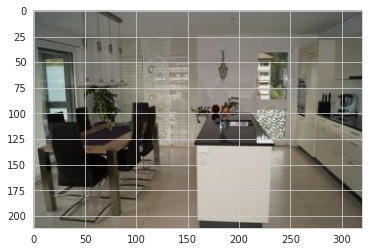

In [18]:
image_plot(list_folder_workable[3])

# Creating a dataset class with the images

In [19]:
#Creating a data set with the demand and the file name (only one image by id for now)
df=data_sub.set_index('Property Reference Id')['Demand'].to_frame()
list_list_image=[glob.glob(list_folder_workable[i]+ "/*") for i in range(len(list_folder_workable))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

data_file=df_filename.join(df,on='Property Reference Id')
data_file.to_csv(PATH+'data.csv')
data_file

,Property Reference Id,File Name,Demand
0,0214.26.6571,/content/drive/MyDrive/Data/Images/0214.26.657...,6.0
1,0214.26.6571,/content/drive/MyDrive/Data/Images/0214.26.657...,6.0
2,0214.26.6571,/content/drive/MyDrive/Data/Images/0214.26.657...,6.0
3,0214.26.6571,/content/drive/MyDrive/Data/Images/0214.26.657...,6.0
4,0214.50.0065,/content/drive/MyDrive/Data/Images/0214.50.006...,0.0
...,...,...,...
600,9500.61.8006,/content/drive/MyDrive/Data/Images/9500.61.800...,1.0
601,9500.61.8006,/content/drive/MyDrive/Data/Images/9500.61.800...,1.0
602,9500.61.8006,/content/drive/MyDrive/Data/Images/9500.61.800...,1.0
603,9500.61.8006,/content/drive/MyDrive/Data/Images/9500.61.800...,1.0


In [20]:
class MyCustomDataset(Dataset):
  def __init__(self,csv_path,img_dir,transform=None):
    df=pd.read_csv(csv_path)
    self.img_dir=img_dir
    self.img_id=df['File Name'].to_frame()
    self.y=df['Demand'].to_frame()
    self.transform=transform

  def __getitem__(self,index):
    img=Image.open(os.path.join(self.img_dir,self.img_id.iloc[index]['File Name']))
    if self.transform:
      img=self.transform(img)
    #Have uniform orientation (should be done in transform?)
    #if np.array(img).shape[0]<np.array(img).shape[1]:
    #  img=img.transpose(Image.ROTATE_90)
    label=torch.tensor(self.y.iloc[index]['Demand'],dtype=torch.float32)
    return img,label

  def __len__(self):
    return self.y.shape[0]





In [59]:
#We work with square image for now
img_size=(150,150)
resize_transformer=transforms.Resize(img_size)
transformer=transforms.Compose([resize_transformer,
                                transforms.ToTensor()])

Demand: tensor(6.)


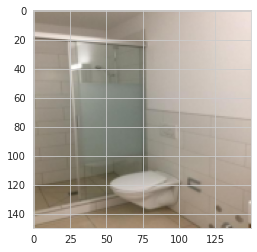

In [60]:
dataset=MyCustomDataset(PATH+'data.csv',PATH+'Images',transform=transformer)
sample=dataset[3]
print('Demand:', sample[1])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

In [61]:
batch_size=64
train_set,test_set=random_split(dataset, lengths=[0.8,0.2])
train_loader=DataLoader(dataset=train_set,batch_size=batch_size,drop_last=True,shuffle=True,pin_memory=torch.cuda.is_available(),num_workers=2)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size)

In [62]:
#data_file['Img Size']=data_file['File Name'].apply(lambda x:np.array(Image.open(x)).shape)
#data_file['Img Size'].value_counts()

# Defining the model

In [63]:
#CNN Network
class ConvNet(nn.Module):
  def __init__(self,img_size=img_size,dim_output=1):
    super(ConvNet,self).__init__()

    #Output size after convolution filter:
    #((width-kernel_size+2Padding)/stride)+1
    
    #Default Input shape (batch_size,num_channel,img_size[0],img_size[1])=(4,3,150,150)
    
    self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
    #Shape=(4,12,150,150)
    self.bn1=nn.BatchNorm2d(num_features=12)
    #Shape=(4,12,150,150)
    self.relu1=nn.ReLU()
    #Shape=(4,12,150,150)

    self.pool=nn.MaxPool2d(kernel_size=2)
    #Reduce the image size by a factor 2
    #Shape=(4,12,75,75)

    self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
    #Shape=(4,20,75,75)
    self.bn2=nn.BatchNorm2d(num_features=20)
    #Shape=(4,20,75,75)
    self.relu2=nn.ReLU()
    #Shape=(4,20,75,75)

    self.fc=nn.Linear(in_features=20*75*75,out_features=dim_output)

  #Feed forward function:

  def forward(self,input):
    output=self.conv1(input)
    output=self.bn1(output)
    output=self.relu1(output)

    output=self.pool(output)

    output=self.conv2(output)
    output=self.bn2(output)
    output=self.relu2(output)

    #Above output will be in matrix form with shape (4,20,75,75)

    output=output.view(-1,20*75*75)

    output=self.fc(output)

    return output



# Model Training

In [80]:
model=ConvNet().to(device)
#Optimizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=torch.nn.MSELoss()
num_epochs=200

for epoch in range(num_epochs):
  model.train()
  
  for i, (images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images=Variable(images.to(device))
      labels=Variable(labels.to(device))
  
    
    optimizer.zero_grad()

    output=model(images)
    loss=loss_function(output,labels.view_as(output))
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss.item())

    

epoch 0 loss 162.964599609375
epoch 1 loss 23.837255477905273
epoch 2 loss 76.61116027832031
epoch 3 loss 47.58051300048828
epoch 4 loss 18.159679412841797
epoch 5 loss 15.970304489135742
epoch 6 loss 12.868549346923828
epoch 7 loss 12.054984092712402
epoch 8 loss 9.154730796813965
epoch 9 loss 8.105680465698242
epoch 10 loss 6.355527400970459
epoch 11 loss 5.303195476531982
epoch 12 loss 5.813661575317383
epoch 13 loss 5.195615768432617
epoch 14 loss 5.181582927703857
epoch 15 loss 3.128945827484131
epoch 16 loss 3.706480026245117
epoch 17 loss 3.3587565422058105
epoch 18 loss 4.048982620239258
epoch 19 loss 2.705320119857788
epoch 20 loss 3.538759231567383
epoch 21 loss 3.3077263832092285
epoch 22 loss 2.1820363998413086
epoch 23 loss 2.7519688606262207
epoch 24 loss 3.7646446228027344
epoch 25 loss 2.6315345764160156
epoch 26 loss 4.040757179260254
epoch 27 loss 2.4276652336120605
epoch 28 loss 3.6021347045898438
epoch 29 loss 1.9675216674804688
epoch 30 loss 1.2930071353912354
epoc

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3534e32040><function _MultiProcessingDataLoaderIter.__del__ at 0x7f3534e32040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

epoch 110 loss 2.7991461753845215


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3534e32040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3534e32040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch 111 loss 2.2229504585266113
epoch 112 loss 1.8041609525680542
epoch 113 loss 2.504373550415039
epoch 114 loss 0.8213416337966919
epoch 115 loss 2.476073741912842
epoch 116 loss 1.7905938625335693
epoch 117 loss 0.9377154111862183
epoch 118 loss 1.5157960653305054
epoch 119 loss 2.2811686992645264
epoch 120 loss 2.269336223602295
epoch 121 loss 1.7702863216400146
epoch 122 loss 1.7843027114868164
epoch 123 loss 1.6320818662643433
epoch 124 loss 1.9855374097824097
epoch 125 loss 1.7772743701934814
epoch 126 loss 1.718630075454712
epoch 127 loss 2.355311632156372
epoch 128 loss 0.9824845194816589
epoch 129 loss 1.3577306270599365
epoch 130 loss 2.3627500534057617
epoch 131 loss 3.473726749420166
epoch 132 loss 1.271355390548706
epoch 133 loss 3.0300040245056152
epoch 134 loss 2.471975803375244
epoch 135 loss 2.3730955123901367
epoch 136 loss 0.7096514701843262
epoch 137 loss 2.165113687515259
epoch 138 loss 2.5563390254974365
epoch 139 loss 1.0117456912994385
epoch 140 loss 1.555126

# Evaluating the model

In [81]:
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error as MSE
def custom_poisson_deviance(y_true,y_pred):
  prediction=y_pred.copy()
  prediction[np.where(prediction<=0)]=10**(-10)
  return mean_poisson_deviance(y_true,prediction)

In [82]:
@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    list_output=[]
    list_target=[]
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        list_output.append(output)
        list_target.append(target)
        test_loss += criterion(output, target.view_as(output)).item() * len(data)
   
    test_loss /= len(val_loader.dataset)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    targets=[item for sublist in list_target for item in sublist]
    targets_values=np.array([x.item() for x in targets])


    print(
        "Test set: Average loss: {:.4f}".format(
            test_loss)
    )
    print('Mean Poisson Deviance: ',custom_poisson_deviance(targets_values,outputs_values),'MSE: ',
    MSE(targets_values,outputs_values))

    return outputs_values,targets_values 


outputs, targets =validate(model,device,val_loader=test_loader,criterion=loss_function)

Test set: Average loss: 28.4089
Mean Poisson Deviance:  6.8666220392651445 MSE:  28.408939571864902
